# Machine Learning in Ocean Remote Sensing

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import math

import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
import cartopy.crs as crs

In [2]:
cb_palette = ['#006BA4', '#FF800E', '#ABABAB']

In [3]:
plt.rcParams.update({'font.size': 16})

## Figure 2

Here we're simply showing that a model trained on continent stratified data won't perform well on other regions.

Basically spatial generalazbility.

Grab the NASA NOMAD dataset but with all the headers removed except the column names

In [5]:
df = pd.read_csv('https://seabass.gsfc.nasa.gov/wiki/NOMAD/nomad_seabass_v2.a_2008200.txt', skiprows=list(range(0,88)) + [89,90])
df = df.rename(columns={'/fields=year': 'year'})

print(df.shape)
df.head()

(4459, 217)


,year,month,day,hour,minute,second,lat,lon,id,oisst,...,allo,diato,lut,zea,chl_b,beta-car,alpha-car,alpha-beta-car,flag,cruise
0,2003,4,15,15,15,0,38.4279,-76.61,1565,3.70,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,20691,ace0301
1,2003,4,15,16,50,0,38.3680,-76.50,1566,3.70,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,20675,ace0301
2,2003,4,15,17,50,0,38.3074,-76.44,1567,3.70,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,20691,ace0301
3,2003,4,17,18,15,0,38.6367,-76.32,1568,3.70,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,20675,ace0301
4,2003,7,21,18,27,0,38.3047,-76.44,1559,22.03,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,20691,ace0302


In [6]:
blue_lw =   'lw443'
blue_es =   'es443'
blue_rrs =  'rrs443'

green_lw =  'lw555'
green_es =  'es555'
green_rrs = 'rrs555'

red_lw =    'lw670'
red_es =    'es670'
red_rrs =   'rrs670'

In [7]:
def chl_fcn(row):
    if row['chl_a'] != -999 :
        return (row['chl_a']) # HPLC
    else:
        return (row['chl']) # flu

df['chl_merge'] = df.apply(lambda row: chl_fcn(row), axis=1)

# whether to use only HPLC or merged chl
# Hu et al 2012 only use HPLC which is chl_a
chl = 'chl_merge' # 'chl_merge'

In [8]:

# make a copy to subset
df_chl = df.copy()

# create the rrs columns
df_chl[blue_rrs] = df_chl[blue_lw]/df_chl[blue_es]
df_chl[green_rrs] = df_chl[green_lw]/df_chl[green_es]
df_chl[red_rrs] = df_chl[red_lw]/df_chl[red_es]

# subset to delete any measurements that are missing
# filter to ensure all the SeaWiFS bands are present
df_chl = df_chl[df_chl['lw443'] != -999]
df_chl = df_chl[df_chl['lw555'] != -999]
df_chl = df_chl[df_chl['lw670'] != -999]
df_chl = df_chl[df_chl['es443'] != -999]
df_chl = df_chl[df_chl['es555'] != -999]
df_chl = df_chl[df_chl['es670'] != -999]
df_chl = df_chl[df_chl['lat'] != -999]
df_chl = df_chl[df_chl['etopo2'] != -999]
df_chl = df_chl[df_chl['lw411'] != -999]
df_chl = df_chl[df_chl['es411'] != -999]
df_chl = df_chl[df_chl['lw489'] != -999]
df_chl = df_chl[df_chl['es489'] != -999]
df_chl = df_chl[df_chl['lw510'] != -999]
df_chl = df_chl[df_chl['es510'] != -999]

df_chl = df_chl[df_chl[chl] != -999]

# subset to only rows that were deeper than 30m
df_chl = df_chl[df_chl['etopo2'] > 30]

# subset to lat between 60N and 60S
df_chl = df_chl[(df_chl['lat'] < 60) & (df_chl['lat'] > -60)]

print("Number of rows remaning after filters: ", len(df_chl))

Number of rows remaning after filters:  487


In [9]:
# don't want any values 0 or below
df_chl = df_chl[np.all(df_chl[[red_es, red_lw, green_lw, blue_lw, chl]] > 0, axis=1)]
print("Number of rows remaning after filters: ", len(df_chl))

Number of rows remaning after filters:  455


Text(0.5, 1.0, 'HPLC chla locations for algorithm development')

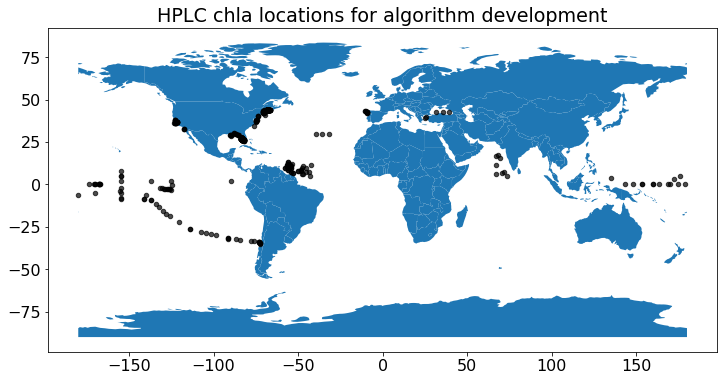

In [10]:
import geopandas as gpd

gdf = gpd.GeoDataFrame(
    df_chl, geometry=gpd.points_from_xy(x=df_chl.lon, y=df_chl.lat, crs=4326)
)
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

fig, ax = plt.subplots(figsize=(12,8))
world.plot(ax=ax)
gdf.plot(color='black',markersize=20,alpha=.7,ax=ax)
ax.set_title('HPLC chla locations for algorithm development')
# fig.savefig('locations_alg_dev.png', dpi=300)

In [28]:
cs = ['orange','brown','purple', 'red', 'green', 'blue']

In [29]:
ocean_regions_gdf = gpd.read_file('data/ne_10m_geography_marine_polys/ne_10m_geography_marine_polys.shp')

In [30]:
ocean_regions_subset = ['South Pacific Ocean','North Pacific Ocean','Black Sea','North Atlantic Ocean','Gulf of Mexico','Arabian Sea']

In [31]:
ocean_regions_ss_gdf = ocean_regions_gdf[ocean_regions_gdf['name'].isin(ocean_regions_subset)]

In [32]:
gdf = gpd.sjoin(gdf, ocean_regions_ss_gdf[['name','geometry']])

In [33]:
np.unique(gdf.name,return_counts=True)

(array(['Arabian Sea', 'Black Sea', 'Gulf of Mexico',
        'North Atlantic Ocean', 'North Pacific Ocean',
        'South Pacific Ocean'], dtype=object),
 array([  7,   3, 113,  71,  54,  61]))

In [34]:
X_main = gdf[gdf.name=='North Pacific Ocean'][[blue_lw, red_lw,green_lw]]
y_main = gdf[gdf.name=='North Pacific Ocean'][chl].values

In [35]:
gdf[gdf.name=='North Pacific Ocean'][[blue_lw, red_lw,green_lw]].shape

(54, 3)

In [36]:
X_test = gdf[gdf.name!='North Pacific Ocean'][[blue_lw, red_lw,green_lw]].values
y_test = gdf[gdf.name!='North Pacific Ocean'][chl].values

In [37]:
class_names_test = gdf[gdf.name!='North Pacific Ocean']['name'].values

In [38]:
from sklearn.model_selection import train_test_split

X_main_train, X_main_test, y_main_train, y_main_test = train_test_split(X_main, y_main, test_size=0.25, random_state=15)

In [39]:
y_main_train.shape

(40,)

In [40]:
X_main_test_idxs = X_main_test.index
X_main_train_idxs = X_main_train.index

X_main_train = X_main_train.values
X_main_test = X_main_test.values

In [41]:
X_main_train.shape, np.log(y_main_train).shape

((40, 3), (40,))

In [42]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(random_state=42)
rf.fit(X_main_train, np.log(y_main_train))

RandomForestRegressor(random_state=42)

In [43]:
import statsmodels.api as sm

In [44]:
ocean_regions_subset

['South Pacific Ocean',
 'North Pacific Ocean',
 'Black Sea',
 'North Atlantic Ocean',
 'Gulf of Mexico',
 'Arabian Sea']

In [45]:
X_test[class_names_test=='North Atlantic Ocean'].shape

(71, 3)

In [46]:
import scipy

In [47]:
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(np.log(y_test[class_names_test=='North Atlantic Ocean']),rf.predict(X_test[class_names_test=='North Atlantic Ocean']))

In [48]:
slope, intercept, r_value, p_value, std_err

(0.910294113496718,
 0.5565467125248391,
 0.7167991556698933,
 2.065458282333193e-12,
 0.10660233593028226)

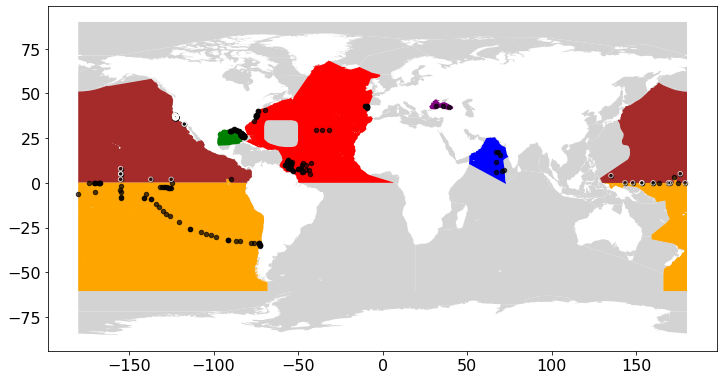

In [49]:
fig, ax = plt.subplots(figsize=(12,8))

ocean_regions_gdf.plot(ax=ax,color='lightgrey')
ocean_regions_gdf[ocean_regions_gdf['name'] == 'South Pacific Ocean'].plot(ax=ax,color='orange')
ocean_regions_gdf[ocean_regions_gdf['name'] == 'North Pacific Ocean'].plot(ax=ax,color='brown')
ocean_regions_gdf[ocean_regions_gdf['name'] == 'Black Sea'].plot(ax=ax,color='purple')
ocean_regions_gdf[ocean_regions_gdf['name'] == 'North Atlantic Ocean'].plot(ax=ax,color='red')
ocean_regions_gdf[ocean_regions_gdf['name'] == 'Gulf of Mexico'].plot(ax=ax,color='green')
ocean_regions_gdf[ocean_regions_gdf['name'] == 'Arabian Sea'].plot(ax=ax,color='blue')

gdf.plot(color='black',markersize=20,alpha=.7,ax=ax)

gdf.loc[X_main_train_idxs].plot(color='None',edgecolor='white',markersize=20,alpha=.7,ax=ax)
# plt.savefig('figs/fig2_world_map_data.png',dpi=300)
plt.show()

In [52]:
from sklearn.metrics import mean_squared_error

South Pacific Ocean
0.6907586171368288


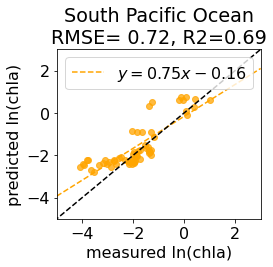

Black Sea
0.9836399922726616


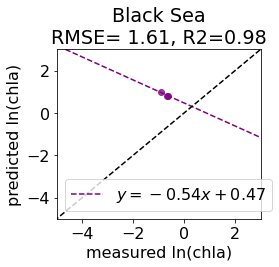

North Atlantic Ocean
0.5138010295690719


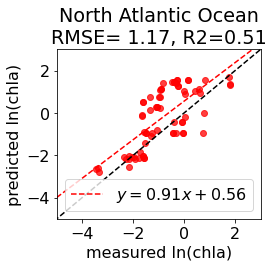

Gulf of Mexico
0.5065510665910715


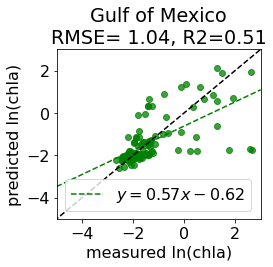

Arabian Sea
0.5873730225699446


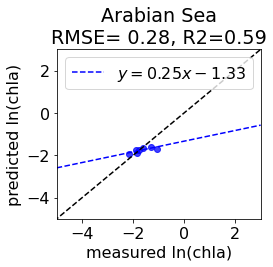

0.84
North Pacific Ocean
0.8665146752339625


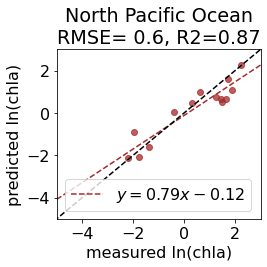

In [53]:
cs = ['orange','purple', 'red', 'green', 'blue']
for idx, region in enumerate(['South Pacific Ocean','Black Sea','North Atlantic Ocean','Gulf of Mexico','Arabian Sea']):
    fig, ax = plt.subplots(figsize=(4,4))
    print(region)
    # print(rf.score(X_test[class_names_test==region],np.log(y_test[class_names_test==region])))
    
    plt.scatter(np.log(y_test[class_names_test==region]),rf.predict(X_test[class_names_test==region]),alpha=0.75,c=cs[idx])
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(np.log(y_test[class_names_test==region]),rf.predict(X_test[class_names_test==region]))
    print(r_value**2)
    plt.axline(xy1=(0, intercept), slope=slope, label=f'$y = {slope:.2f}x {intercept:+.2f}$', ls='--',c=cs[idx])
    plt.legend()
    plt.xlim(-5,3)
    plt.ylim(-5,3)
    plt.xlabel('measured ln(chla)')
    plt.ylabel('predicted ln(chla)')
    plt.plot([np.log(10e-5), np.log(50)], [np.log(10e-5), np.log(50)], ls="--",c='k')
    plt.title(region+'\nRMSE= '+str(np.round(mean_squared_error(np.log(y_test[class_names_test==region]),rf.predict(X_test[class_names_test==region]), squared=False),2))+', R2='+str(np.round(r_value**2,2)))
    

    
    plt.tight_layout()
    plt.savefig('figs/fig2_'+region+'_metrics.png',dpi=300,transparent=True)
    
    plt.show()
print(np.round(rf.score(X_main_test,np.log(y_main_test)),2))

print('North Pacific Ocean')

fig, ax = plt.subplots(figsize=(4,4))
plt.scatter(np.log(y_main_test),rf.predict(X_main_test),alpha=0.75,c='brown')
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(np.log(y_main_test),rf.predict(X_main_test))
print(r_value**2)
plt.axline(xy1=(0, intercept), slope=slope, label=f'$y = {slope:.2f}x {intercept:+.2f}$', ls='--',c='brown')
plt.legend()
plt.plot([np.log(10e-5), np.log(50)], [np.log(10e-5), np.log(50)], ls="--",c='k')
plt.xlim(-5,3)
plt.ylim(-5,3)
plt.xlabel('measured ln(chla)')
plt.ylabel('predicted ln(chla)')
plt.title('North Pacific Ocean'+'\nRMSE= '+str(np.round(mean_squared_error(np.log(y_main_test),rf.predict(X_main_test), squared=False),2))+', R2='+str(np.round(r_value**2,2)))
plt.tight_layout()
plt.savefig('figs/fig2_'+'North Pacific Ocean'+'_metrics.png',dpi=300,transparent=True)
plt.show()